In [1]:
import os
import scipy.stats
import pandas as pd
import numpy as np
import math
from prettytable import PrettyTable
from operator import itemgetter
import matplotlib.pyplot as plt

## Computing number of samples as a function of epsilon and the other way around

In [2]:
def compute_n(c, delta, epsilon, size_of_market):
    return (c / epsilon) * (c / epsilon) * 0.5 * math.log((2 * size_of_market) / delta)

In [3]:
def compute_eps(c, delta, size_of_market, number_of_samples):
    return c * math.sqrt((math.log((2.0 * size_of_market) / delta)) / (2.0 * number_of_samples))

In [4]:
candidate_eps = [0.125, 0.25, 0.5, 1.0]
for eps in candidate_eps:
    m_eps = compute_n(2, 0.1, eps, 4480)
    print([int(m_eps /4) , int(m_eps / 2), int(m_eps), int(2 * m_eps)])

[364, 729, 1459, 2919]
[91, 182, 364, 729]
[22, 45, 91, 182]
[5, 11, 22, 45]


### Testing eps to n and n to eps functions

In [5]:
c = 2
delta = 0.1
epsilon = 1.0
size_of_market = 4480
n = compute_n(c, delta, epsilon, size_of_market)
assert epsilon == compute_eps(c, delta, size_of_market, n)
assert n == compute_n(c, delta, epsilon, size_of_market)

## Compute Statistics from LSVM worlds

In [6]:
def compare_ea_eap(loc, world_number):
    # Read EAP data.
    bidders_final_values_df = pd.read_csv(f"{loc}bidders_final_values.csv")
    eap_samples = bidders_final_values_df['n'].sum()
    
    # Compute EA data.
    bidders_summary_df = pd.read_csv(f"{loc}bidders_summary.csv")
    params_csv = pd.read_csv(f"{loc}params.csv")
    c, delta, epsilon = int(params_csv.iloc[3]['value']), sum(eval(params_csv.iloc[1]['value'])), float(params_csv.iloc[6]['value'])
    size_of_market = sum([2 ** len(eval(row[2])) for row in bidders_summary_df.itertuples()])
    ea_samples = compute_n(c, delta, epsilon, size_of_market) * size_of_market
    #print(f"c = {c}, delta = {delta}, epsilon = {epsilon : .4f}, size_of_market = {size_of_market}")
    #print(f"{ ea_samples : ,.0f}")
    #print(f"{ eap_samples : ,}")
    
    return [world_number, 
            c, 
            delta, 
            epsilon, 
            size_of_market,
            ea_samples, 
            eap_samples,
            (eap_samples / ea_samples) * 100.0]

In [7]:
def construct_ea_eap_ptable(results, sort_key=7):
    # Sort by desired key
    results = sorted(results, key=itemgetter(sort_key))
    # Construct ptable
    results_ptable = PrettyTable()
    results_ptable.field_names = ['world', 'c', 'delta', 'epsilon', 'size_of_market', 'ea', 'eap', 'ratio']
    results_ptable.align["ea"] = "r"
    results_ptable.align["eap"] = "r"

    for r in results:
        results_ptable.add_row([r[0], 
                                r[1], 
                                r[2], 
                                f"{r[3] : .4f}", 
                                f"{r[4] : ,}", 
                                f"{r[5] : ,.0f}", 
                                f"{r[6] : ,.0f}", 
                                f"{r[7] : .4f}"])
    return results_ptable

#Collect results from all experiments. 
results_dir = '../experiments/LSVM/'
results = []
for e in [0, 1]:
    for i in range(0, 11):
        loc = f"{results_dir}{e}/worlds_results/world{i}/eps_0.125/"
        results += [compare_ea_eap(loc, i)]
print(construct_ea_eap_ptable(results))

+-------+---+-------+---------+----------------+----------------+--------------+----------+
| world | c | delta | epsilon | size_of_market |             ea |          eap |  ratio   |
+-------+---+-------+---------+----------------+----------------+--------------+----------+
|   7   | 2 |  0.1  |  0.0848 |     263,168    |  1,132,820,799 |  196,852,416 |  17.3772 |
|   0   | 2 |  0.1  |  0.0877 |     264,576    |  1,066,245,240 |  308,778,690 |  28.9594 |
|   4   | 2 |  0.1  |  0.0880 |     263,616    |  1,054,005,368 |  329,674,432 |  31.2782 |
|   3   | 2 |  0.1  |  0.0881 |     263,616    |  1,051,992,133 |  335,523,766 |  31.8941 |
|   5   | 2 |  0.1  |  0.0881 |     265,536    |  1,059,584,322 |  339,889,286 |  32.0776 |
|   0   | 2 |  0.1  |  0.0882 |     264,832    |  1,053,896,024 |  346,957,299 |  32.9214 |
|   10  | 2 |  0.1  |  0.0886 |     264,192    |  1,043,114,765 |  372,940,946 |  35.7526 |
|   9   | 2 |  0.1  |  0.0887 |     263,872    |  1,039,161,207 |  382,385,649 |

## Plots

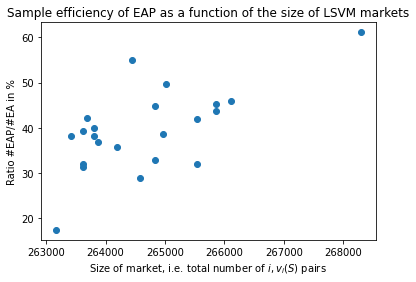

In [8]:
results = sorted(results, key=itemgetter(4), reverse=True)
fig, ax = plt.subplots()
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.scatter([result[4] for result in results], [result[7] for result in results])
plt.xlabel(r'Size of market, i.e. total number of $i, v_i(S)$ pairs')
plt.ylabel('Ratio #EAP/#EA in %')
plt.title('Sample efficiency of EAP as a function of the size of LSVM markets')
plt.show()

In [9]:
def compute_conf_interval(sample, confidence_level = 0.95):
    degrees_freedom = len(sample) - 1
    sample_mean = np.mean(sample)
    sample_standard_error = scipy.stats.sem(sample)
    lb, ub = scipy.stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)

    return sample_mean, lb, ub, (ub - lb)/2

confidence = 0.95
for eps in ['0.125', '0.25', '0.5', '1.0']:
    #data = [compare_ea_eap(f"../experiments/GSVM/{e}/worlds_results/world{i}/eps_{eps}/", i) for i in range(0, 30) for e in [0, 1]]
    data = [compare_ea_eap(f"../experiments/LSVM/{e}/worlds_results/world{i}/eps_{eps}/", i) for i in range(0, 11) for e in [0, 1]]
    eps_eap = [data[3] for data in data]
    num_samples_eap = [data[6] for data in data]
    size_of_market = [compute_n(int(data[1]), float(data[2]), float(eps), int(data[4])) * int(data[4]) for data in data]
    mean_eap_eps, lb_eap_eps, ub_eap_eps, width_ci_eap_eps = compute_conf_interval(eps_eap, confidence)
    mean_eap, lb_eap, ub_eap, width_ci_eap = compute_conf_interval(num_samples_eap, confidence)
    mean_ea, lb_ea, ub_ea, width_ci_ea = compute_conf_interval(size_of_market, confidence)
    print(f"{eps} ", end='')
    print(f"${mean_ea / 1000 :,.0f} \pm {width_ci_ea / 1000 :,.2f}$ & ", end='')
    print(f"${mean_eap / 1000 :,.0f} \pm {width_ci_eap / 1000 :,.2f}$ &", end='')
    print(f"${mean_eap_eps :.4f} \pm {width_ci_eap_eps :.4f}$ ")


0.125 $524,487 \pm 1,123.29$ & $409,901 \pm 39,475.80$ &$0.0888 \pm 0.0005$ 
0.25 $131,122 \pm 280.82$ & $103,076 \pm 9,911.05$ &$0.1776 \pm 0.0010$ 
0.5 $32,780 \pm 70.21$ & $25,988 \pm 2,497.34$ &$0.3559 \pm 0.0020$ 
1.0 $8,195 \pm 17.55$ & $6,561 \pm 630.28$ &$0.7170 \pm 0.0038$ 


In [10]:
eps = 0.25
data = [compare_ea_eap(f"../experiments/LSVM/{e}/worlds_results/world{i}/eps_{eps}/", i) 
                               for i in range(0, 11) for e in [0, 1]]
print(construct_ea_eap_ptable(data, 4))

+-------+---+-------+---------+----------------+--------------+--------------+----------+
| world | c | delta | epsilon | size_of_market |           ea |          eap |  ratio   |
+-------+---+-------+---------+----------------+--------------+--------------+----------+
|   7   | 2 |  0.1  |  0.1697 |     263,168    |  282,727,969 |   49,451,598 |  17.4909 |
|   9   | 2 |  0.1  |  0.1777 |     263,424    |  258,244,209 |   99,111,214 |  38.3789 |
|   3   | 2 |  0.1  |  0.1763 |     263,616    |  262,660,452 |   84,453,510 |  32.1531 |
|   4   | 2 |  0.1  |  0.1761 |     263,616    |  263,163,147 |   82,976,042 |  31.5303 |
|   6   | 2 |  0.1  |  0.1779 |     263,616    |  257,785,820 |  101,990,524 |  39.5641 |
|   2   | 2 |  0.1  |  0.1784 |     263,680    |  256,368,097 |  108,547,314 |  42.3404 |
|   3   | 2 |  0.1  |  0.1777 |     263,808    |  258,640,254 |   99,407,416 |  38.4346 |
|   8   | 2 |  0.1  |  0.1781 |     263,808    |  257,600,262 |  103,608,498 |  40.2206 |
|   9   | 